In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
from spillover_noise_q_env_config import (
    q_env_config as gate_q_env_config,
    circuit_context,
    gamma,
    phi,
)
from spillover_noise_quantum_environment import SpilloverNoiseQuantumEnvironment
from gymnasium.wrappers import RescaleAction, ClipAction

from rl_qoc import CustomPPO
from rl_qoc.helpers import load_from_yaml_file

from rl_qoc.agent import (
    TotalUpdates,
    HardwareRuntime,
    TrainingConfig,
    TrainFunctionSettings,
)

import logging

logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s INFO %(message)s",  # hardcoded INFO level
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

In [2]:
q_env = SpilloverNoiseQuantumEnvironment(gate_q_env_config, circuit_context, (phi, gamma))
rescaled_env = RescaleAction(ClipAction(q_env), -1.0, 1.0)

In [3]:
print("Reward method:", q_env.config.reward_method)
print("n_reps:", q_env.n_reps)
print("backend", q_env.backend)
print("backend Options", q_env.backend.options)

Reward method: channel
n_reps: 1
backend AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['rx_custom']>)
backend Options Options(shots=1024, method='automatic', device='CPU', precision='double', executor=None, max_job_size=None, max_shot_size=None, enable_truncation=True, zero_threshold=1e-10, validation_threshold=None, max_parallel_threads=None, max_parallel_experiments=0, max_parallel_shots=None, max_memory_mb=None, fusion_enable=True, fusion_verbose=False, fusion_max_qubit=None, fusion_threshold=None, accept_distributed_results=None, memory=None, noise_model=<NoiseModel on ['rx_custom']>, seed_simulator=None, cuStateVec_enable=False, blocking_qubits=None, blocking_enable=False, chunk_swap_buffer_qubits=None, batched_shots_gpu=False, batched_shots_gpu_max_qubits=16, num_threads_per_device=1, shot_branching_enable=False, shot_branching_sampling_enable=False, statevector_parallel_threshold=14, statevector_sample_measure_opt=10, stabilizer_max_snapshot_probabilities

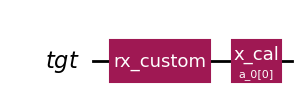

In [4]:
q_env.circuits[0].draw("mpl")

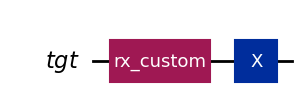

In [5]:
q_env.baseline_circuits[0].draw("mpl")

In [6]:
from qiskit.quantum_info import Operator

Operator(q_env.baseline_circuits[0]).draw("latex")

<IPython.core.display.Latex object>

In [7]:
q_env.get_baseline_fid_from_phi_gamma()

0.9636688413961226

In [8]:
from qiskit.quantum_info import (
    Operator,
    average_gate_fidelity,
    Statevector,
    state_fidelity,
)

average_gate_fidelity(Operator(q_env._get_noisy_circuit()), Operator(q_env._get_ideal_circ()))

0.9636688413961226

In [9]:
agent_config = load_from_yaml_file("agent_config.yaml")

In [10]:
ppo_agent = CustomPPO(agent_config, rescaled_env)

total_updates = TotalUpdates(100)
# hardware_runtime = HardwareRuntime(300)
training_config = TrainingConfig(
    training_constraint=total_updates,
    target_fidelities=[0.999, 0.9999],
    lookback_window=10,
    anneal_learning_rate=False,
    std_actions_eps=1e-2,
)

train_function_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=False,
)

In [11]:
q_env.unwrapped.n_reps

1

In [12]:
from qiskit_aer.primitives import EstimatorV2

q_env.estimator._backend
q_env.estimator.options

Options(default_precision=0.0, backend_options={}, run_options={})

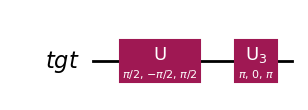

In [13]:
q_env.baseline_circuits[0].decompose().draw("mpl")

In [14]:
from qiskit.primitives import BackendEstimatorV2

switch_estimator = False
if switch_estimator:
    q_env.estimator = BackendEstimatorV2(backend=q_env.backend)

In [39]:
training_results = ppo_agent.train(
    training_config=training_config, train_function_settings=train_function_settings
)

2024-08-14 10:41:53 INFO Training Constraint: Total Updates


  0%|          | 0/100 [00:00<?, ?it/s]

Starting simulation benchmark...
Fidelity stored 0.974429285269088


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit/providers/backend_compat.py:126: RuntimeWarning: No gate definition for store can be found and is being excluded from the generated target. You can use `custom_name_mapping` to provide a definition for this operation.
  warnings.warn(


Hardware runtime taken: 15.4176
Sending Estimator job...


KeyboardInterrupt: 

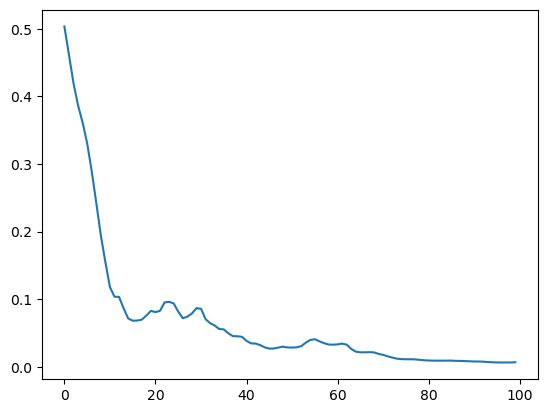

In [16]:
plt.plot(ppo_agent.training_results["std_action"])

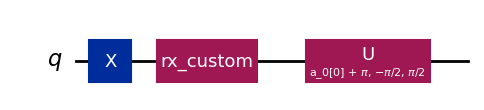

In [17]:
q_env._pubs[0][0].draw("mpl")

In [18]:
max_fid_index = np.argmax(ppo_agent.training_results["fidelity_history"])
np.cumsum(ppo_agent.training_results["hardware_runtime"], dtype=float)[max_fid_index]

48.153600000000004

In [19]:
ppo_agent.training_results["fidelity_history"][max_fid_index]

0.9970876689230734

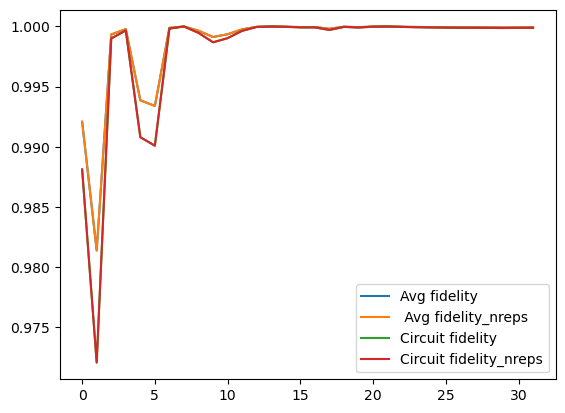

In [30]:
n_reps = q_env.unwrapped.n_reps
plt.plot(q_env.fidelity_history, label="Avg fidelity")
plt.plot(q_env.avg_fidelity_history_nreps, label=" Avg fidelity_nreps")
plt.plot(q_env.circuit_fidelity_history, label="Circuit fidelity")
plt.plot(q_env.circuit_fidelity_history_nreps, label="Circuit fidelity_nreps")
plt.legend()

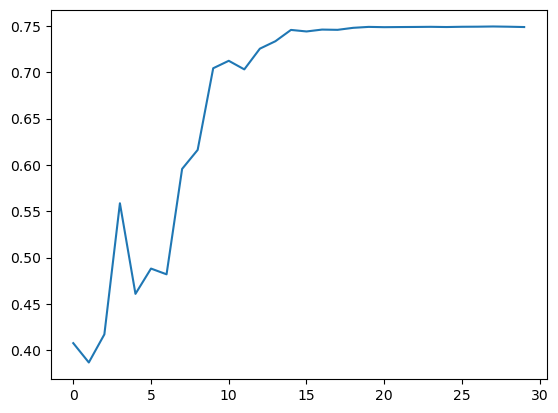

In [31]:
plt.plot(np.mean(q_env.unwrapped.reward_history, axis=1))

In [32]:
ppo_agent.training_results["best_action_vector"]

array([-0.4935522], dtype=float32)

In [23]:
save_fig_file_name = "plot_measurement_error_phi-0.05_gamma-0.025.pdf"

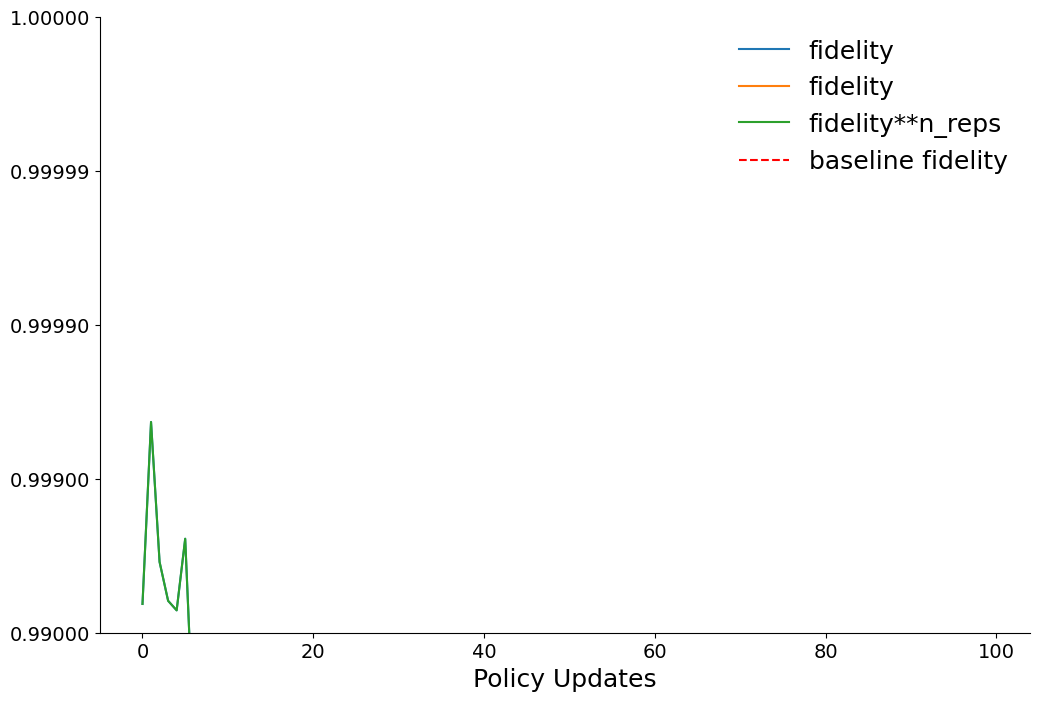

In [24]:
def transform_scale(data):
    return np.log10(1 - np.array(data))


# Load data from all files
baseline_fidelity = q_env.get_baseline_fid_from_phi_gamma()

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the best seed with distinct color and solid line
# ax.plot(transform_scale(training_results["avg_reward"]), label='reward') #, color='blue')
ax.plot(
    transform_scale(ppo_agent.training_results["fidelity_history"]), label="fidelity"
)  # , color='red')
ax.plot(ppo_agent.training_results["fidelity_history"], label="fidelity")
# ax.plot(
#     transform_scale(training_results["fidelity_history_nreps"]), label="fidelity_nreps"
# )
ax.plot(
    transform_scale(np.array(ppo_agent.training_results["fidelity_history"]) ** n_reps),
    label="fidelity**n_reps",
)
max_fidelity = max(ppo_agent.training_results["fidelity_history"])
max_fidelity_index = ppo_agent.training_results["fidelity_history"].index(max_fidelity)

plt.axhline(
    y=transform_scale(baseline_fidelity),
    color="r",
    linestyle="--",
    label="baseline fidelity",
)

# Deactivate the top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add labels and a legend
ax.set_xlabel("Policy Updates", fontsize=18)
# Customize the ticks
y_ticks = [0.99, 0.999, 0.9999, 0.99999, 0.999999]  # Manually specifying the ticks
ax.set_yticks(transform_scale(y_ticks))
ax.set_yticklabels(y_ticks)

# Set the y-tick labels to the original y-tick values
ax.set_yticklabels([f"{ytick:.5f}" for ytick in y_ticks])

# Transform the y-axis data
ax.set_ylim(transform_scale(0.99), transform_scale(0.999999))

ax.legend(frameon=False, fontsize=18)
ax.tick_params(axis="both", which="minor", labelsize=12)
ax.tick_params(axis="both", which="major", labelsize=14)

# Calculate the cumulative hardware runtime up to the max fidelity index
cumulative_hardware_runtime = sum(
    ppo_agent.training_results["hardware_runtime"][: max_fidelity_index + 1]
)

# Add the maximum fidelity value and hardware runtime as text on the plot
text_str = f"Max Fidelity: {max_fidelity:.6f}\nHardware Runtime: {cumulative_hardware_runtime:.2f}s\n Update Step: {max_fidelity_index + 1}"
# ax.text(0.35, 0.1, text_str, transform=ax.transAxes, fontsize=16,
#         verticalalignment='center_baseline', horizontalalignment='center',
#         bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

# Show the plot
# plt.savefig(save_fig_file_name, format="pdf", bbox_inches="tight")
plt.show()

In [25]:
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, ReadoutError, reset_error

n_qubits = 2

circ = QuantumCircuit(n_qubits)
circ.x(0)
circ.measure_all()

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(reset_error(0.01), "reset")

readout_assignment_error = 1.310e-2  # Taken from IBMQ Sherbrooke (median readout assignment error)
# readout_error_matrix = get_readout_error_matrix(n_qubits=1, readout_assignment_error=readout_assignment_error)
readout_error_matrix = ReadoutError(
    [
        [1 - readout_assignment_error, readout_assignment_error],
        [readout_assignment_error, 1 - readout_assignment_error],
    ]
)
noise_model.add_all_qubit_readout_error(readout_error_matrix, "measure")

backend = AerSimulator(noise_model=noise_model, coupling_map=CouplingMap.from_full(n_qubits))

In [26]:
circ_transpiled = transpile(circ, backend, optimization_level=0)

In [27]:
q_env.mean_action

array([1.0884902], dtype=float32)

In [2]:
ppo_agent.actions

NameError: name 'ppo_agent' is not defined

In [42]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(1)
qc.rx(phi, 0)
qc.rx(gamma * phi, 0)
qc.rx(np.pi + q_env.mean_action[0], 0)
Operator(qc).draw("latex")

<IPython.core.display.Latex object>

In [43]:
q_env.target.target_operator.draw("latex")

<IPython.core.display.Latex object>

In [44]:
q_env.target.Chi

array([ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.01465364e-17,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.01465364e-17,  0.00000000e+00, -1.79380389e-16,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.00000000e+00, -1.89526925e-16])

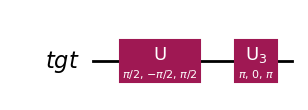

In [45]:
q_env.target.target_circuit.decompose().draw("mpl")

In [46]:
from qiskit.quantum_info import Operator, average_gate_fidelity

average_gate_fidelity(Operator(qc), q_env.target.target_operator)

0.6703556517029039

In [47]:
q_env.fidelity_history[-1]

0.6703556517029039

In [35]:
q_env.mean_action / np.pi

array([0.3464772], dtype=float32)

In [36]:
ppo_agent.actions[-1]

tensor([[0.3547],
        [0.3500],
        [0.3356],
        [0.3458],
        [0.3447],
        [0.3361],
        [0.3560],
        [0.3538],
        [0.3251],
        [0.3362],
        [0.3422],
        [0.3412],
        [0.3457],
        [0.3550],
        [0.3484],
        [0.3451],
        [0.3460],
        [0.3399],
        [0.3436],
        [0.3372],
        [0.3384],
        [0.3497],
        [0.3355],
        [0.3370],
        [0.3510],
        [0.3410],
        [0.3448],
        [0.3564],
        [0.3467],
        [0.3503],
        [0.3515],
        [0.3453]])